In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from pylab import rcParams

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import r2_score

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import seaborn as sns

import base64 
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
from IPython.core.display import display, HTML

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
print("---------Modules Imported-----------")

---------Modules Imported-----------


# Import data as python dataframe

First, the data is imported from the source i.e., spi_matches_latest.csv which contains the data from multiple league. Among those multiple leagues, I will just use the rows with 'barclays premier league' as league.

In [206]:
df = pd.read_csv('../data/raw/spi_matches.csv')
df.columns

Index(['season', 'date', 'league_id', 'league', 'team1', 'team2', 'spi1',
       'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2',
       'importance1', 'importance2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1',
       'nsxg2', 'adj_score1', 'adj_score2'],
      dtype='object')

In [207]:
df.describe()

,season,league_id,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
count,42182.000000,42182.000000,42182.000000,42182.000000,42182.000000,42182.000000,42182.000000,42182.000000,42182.000000,29834.000000,29834.000000,34531.000000,34531.000000,18393.000000,18393.000000,18393.000000,18393.000000,18393.000000,18393.000000
mean,2018.411882,2181.580556,44.753756,44.716923,0.446575,0.300392,0.253034,1.515537,1.171632,31.341932,30.640085,1.524167,1.181431,1.501028,1.170395,1.407611,1.135033,1.540532,1.190819
std,1.174635,901.657833,18.965022,18.981159,0.157900,0.142988,0.047277,0.425628,0.419116,26.185455,25.830351,1.283645,1.142299,0.829679,0.734815,0.653051,0.570872,1.246655,1.128479
min,2016.000000,1818.000000,3.880000,4.040000,0.027100,0.003200,0.000000,0.250000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,1849.000000,30.990000,30.990000,0.346600,0.207200,0.235200,1.240000,0.910000,10.900000,10.300000,1.000000,0.000000,0.880000,0.620000,0.950000,0.730000,1.050000,0.000000
50%,2018.000000,1874.000000,42.670000,42.585000,0.437600,0.284900,0.261200,1.450000,1.120000,26.100000,25.200000,1.000000,1.000000,1.370000,1.040000,1.320000,1.050000,1.050000,1.050000
75%,2019.000000,2160.000000,58.100000,58.060000,0.535500,0.375075,0.281800,1.710000,1.380000,45.400000,44.600000,2.000000,2.000000,1.970000,1.560000,1.750000,1.430000,2.100000,2.100000
max,2020.000000,9541.000000,96.570000,96.780000,0.977500,0.899200,0.453700,4.900000,4.010000,100.000000,100.000000,11.000000,9.000000,7.070000,6.200000,6.890000,5.920000,9.150000,7.930000


In [208]:
df_epl = df.loc[df['league'] == 'Barclays Premier League']
df_epl.head()
print('\n', '-'*25, 'Statistics', '-'*25, '\n')
df_epl.describe()
print('\n', '-'*25, 'Nan Count', '-'*25, '\n')
df_epl.isna().sum()

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
12,2016,2016-08-13,2411,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,...,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,2.10,1.05
13,2016,2016-08-13,2411,Barclays Premier League,Middlesbrough,Stoke City,56.32,60.35,0.4380,0.2692,...,33.9,32.5,1.0,1.0,1.40,0.55,1.13,1.06,1.05,1.05
14,2016,2016-08-13,2411,Barclays Premier League,Burnley,Swansea City,58.98,59.74,0.4482,0.2663,...,36.5,29.1,0.0,1.0,1.24,1.84,1.71,1.56,0.00,1.05
15,2016,2016-08-13,2411,Barclays Premier League,Southampton,Watford,69.49,59.33,0.5759,0.1874,...,34.1,30.7,1.0,1.0,1.05,0.22,1.52,0.41,1.05,1.05
16,2016,2016-08-13,2411,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,...,31.9,48.0,1.0,1.0,0.73,1.11,0.88,1.81,1.05,1.05



 ------------------------- Statistics ------------------------- 



,season,league_id,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
count,1900.000000,1900.0,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1534.000000,1534.000000,1558.000000,1558.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000
mean,2018.000000,2411.0,70.126563,70.077721,0.451428,0.313440,0.235133,1.589574,1.238595,35.450913,33.958214,1.558408,1.222080,1.564297,1.260218,1.569075,1.286981,1.562049,1.230796
std,1.414586,0.0,11.753527,11.760391,0.198494,0.181893,0.050772,0.525003,0.515597,26.417612,25.803175,1.313969,1.209351,0.901515,0.793443,0.823370,0.691640,1.285595,1.178842
min,2016.000000,2411.0,42.970000,43.410000,0.034600,0.008000,0.053100,0.430000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.030000,0.000000,0.000000
25%,2017.000000,2411.0,60.700000,60.650000,0.320275,0.188100,0.208800,1.237500,0.910000,12.700000,11.400000,1.000000,0.000000,0.870000,0.670000,0.990000,0.780000,1.050000,0.000000
50%,2018.000000,2411.0,68.585000,68.700000,0.440100,0.285200,0.249350,1.470000,1.160000,32.750000,31.750000,1.000000,1.000000,1.420000,1.100000,1.430000,1.180000,1.050000,1.050000
75%,2019.000000,2411.0,80.195000,79.955000,0.565975,0.412325,0.271000,1.830000,1.510000,53.600000,52.900000,2.000000,2.000000,2.120000,1.710000,1.990000,1.650000,2.100000,2.100000
max,2020.000000,2411.0,95.750000,95.470000,0.938900,0.866000,0.336400,3.490000,3.280000,100.000000,100.000000,8.000000,9.000000,7.070000,5.100000,6.580000,4.310000,8.030000,7.050000



 ------------------------- Nan Count ------------------------- 



season           0
date             0
league_id        0
league           0
team1            0
team2            0
spi1             0
spi2             0
prob1            0
prob2            0
probtie          0
proj_score1      0
proj_score2      0
importance1    366
importance2    366
score1         342
score2         342
xg1            343
xg2            343
nsxg1          343
nsxg2          343
adj_score1     343
adj_score2     343
dtype: int64

- **Looking at the nan count result, we find that there are null value for score1 and score2. Lets first visualize it based on the season.**

,score1
season,
2016,380
2017,380
2018,380
2019,380
2020,38


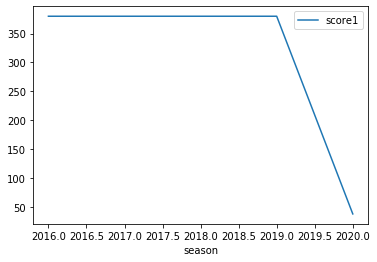

In [209]:
count_season = df_epl[['season', 'score1']].groupby('season').count()
count_season.plot()
count_season

- **From this table/plot, we can find that most of the scores with null are for 2020 season. Although, the season had resumed and the score should be updates, it is not updated. So, we will later remove all the rows having value as NaN.**

# Now, lets visualize the scores for home and away games.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123c49b10>]],
      dtype=object)

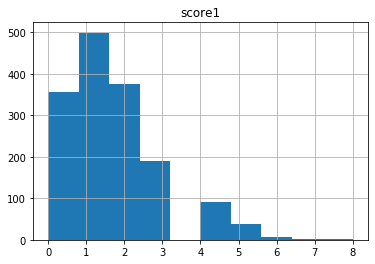

In [210]:
df_epl.hist('score1')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124a9d2d0>]],
      dtype=object)

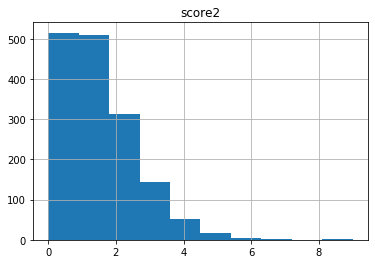

In [211]:
df_epl.hist('score2')

- **Based on these two plots of score1 and score2, we can find that the team scores more when they are playing in their home.**
- **In home game, the highest frequency of goal scored is 1, while in away game, the highest frequency is of not scoring a goal.**
- **Also, we can find that there is a rare occasion when the away team score more than 5 goals.**

# Now, lets visualize the importance for home and away games.
Importance in the dataset is defined as "How important the game is for the team?"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1255a8ad0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124fda450>]],
      dtype=object)

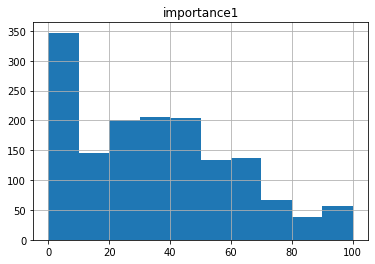

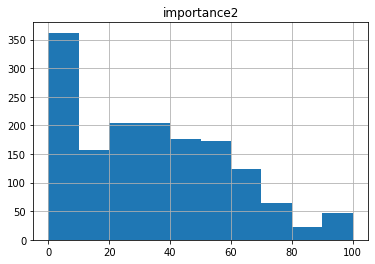

In [212]:
df_epl.hist('importance1')
df_epl.hist('importance2')

- **As both the plot are similar, we can say that the importance is not dependent on the home and away games.**

# Lets be more specific and analyze for a single team. 
We will extract data for Liverpool.

In [213]:
df_liverpool = df_epl.loc[(df_epl['team1'] == 'Liverpool') | (df_epl['team2'] == 'Liverpool')]
df_liverpool.describe()

,season,league_id,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
count,190.00000,190.0,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,154.000000,154.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,2018.00000,2411.0,78.373947,78.504579,0.464877,0.346139,0.188988,1.792842,1.415211,47.264935,46.124026,1.871795,1.288462,1.779103,1.350577,1.584551,1.390385,1.874808,1.310449
std,1.41795,0.0,12.816878,12.718948,0.281778,0.255423,0.048140,0.733215,0.720243,31.010484,31.466060,1.589148,1.202200,1.071959,0.857918,0.861332,0.808930,1.564158,1.203091
min,2016.00000,2411.0,45.810000,48.010000,0.054200,0.008700,0.057000,0.610000,0.200000,0.000000,0.000000,0.000000,0.000000,0.140000,0.050000,0.050000,0.030000,0.000000,0.000000
25%,2017.00000,2411.0,67.805000,67.697500,0.190625,0.089400,0.158875,1.120000,0.722500,23.750000,16.700000,1.000000,0.000000,0.910000,0.667500,0.837500,0.695000,1.050000,0.000000
50%,2018.00000,2411.0,81.345000,81.495000,0.427450,0.333600,0.198350,1.765000,1.525000,52.750000,51.800000,2.000000,1.000000,1.660000,1.185000,1.515000,1.240000,1.585000,1.050000
75%,2019.00000,2411.0,88.810000,88.810000,0.739900,0.589500,0.227675,2.415000,2.025000,67.750000,68.150000,3.000000,2.000000,2.512500,1.965000,2.230000,1.955000,3.150000,2.100000
max,2020.00000,2411.0,94.660000,95.440000,0.934400,0.818000,0.264000,3.340000,2.830000,100.000000,100.000000,7.000000,5.000000,4.820000,4.240000,3.830000,3.880000,7.230000,4.320000


In [214]:
df_liverpool_home = df_liverpool.loc[df_liverpool['team1'] == 'Liverpool']
df_liverpool_away = df_liverpool.loc[df_liverpool['team2'] == 'Liverpool']
df_liverpool_home.head()
df_liverpool_away.head()
df_liverpool_home.describe()
df_liverpool_away.describe()


,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
145,2016,2016-09-10,2411,Barclays Premier League,Liverpool,Leicester City,78.41,67.06,0.6145,0.1637,...,65.4,33.5,4.0,1.0,2.81,1.34,2.36,1.16,3.71,1.05
293,2016,2016-09-24,2411,Barclays Premier League,Liverpool,Hull City,79.92,52.27,0.7404,0.0832,...,67.9,29.9,5.0,1.0,4.82,0.17,3.71,0.34,5.24,1.05
442,2016,2016-10-17,2411,Barclays Premier League,Liverpool,Manchester United,81.60,80.72,0.4737,0.2815,...,66.9,70.1,0.0,0.0,0.31,0.68,1.49,0.41,0.00,0.00
480,2016,2016-10-22,2411,Barclays Premier League,Liverpool,West Bromwich Albion,81.26,59.19,0.7223,0.0976,...,65.1,19.4,2.0,1.0,2.48,0.84,1.95,1.24,2.10,1.05
621,2016,2016-11-06,2411,Barclays Premier League,Liverpool,Watford,81.35,62.10,0.7130,0.1086,...,64.3,9.3,6.0,1.0,4.01,0.98,3.60,0.80,5.78,1.05


,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
26,2016,2016-08-14,2411,Barclays Premier League,Arsenal,Liverpool,82.55,77.44,0.5551,0.2115,...,62.7,63.9,3.0,4.0,1.14,1.84,1.19,1.49,3.15,4.20
39,2016,2016-08-20,2411,Barclays Premier League,Burnley,Liverpool,57.85,78.87,0.2079,0.5520,...,31.4,56.4,2.0,0.0,0.21,1.19,0.33,2.36,2.10,0.00
74,2016,2016-08-27,2411,Barclays Premier League,Tottenham Hotspur,Liverpool,73.71,78.14,0.3967,0.3444,...,55.0,64.1,1.0,1.0,0.70,1.93,1.69,1.39,1.05,1.05
194,2016,2016-09-16,2411,Barclays Premier League,Chelsea,Liverpool,81.72,79.28,0.5080,0.2532,...,57.8,61.6,1.0,2.0,1.32,1.47,2.08,1.17,1.05,2.10
350,2016,2016-10-01,2411,Barclays Premier League,Swansea City,Liverpool,58.64,81.61,0.1616,0.6340,...,33.4,55.2,1.0,2.0,2.45,2.50,0.73,2.37,1.05,2.10


,season,league_id,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
count,95.000000,95.0,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,77.000000,77.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,2018.000000,2411.0,87.828211,69.328316,0.709801,0.124760,0.165442,2.416632,0.809789,61.627273,34.983117,2.615385,0.743590,2.362308,0.819231,2.207436,0.782179,2.592308,0.775385
std,1.421716,0.0,4.962802,11.388328,0.155265,0.108003,0.051250,0.426052,0.413195,29.024425,28.678552,1.479125,0.874396,1.005233,0.522918,0.671038,0.403506,1.445441,0.910858
min,2016.000000,2411.0,76.450000,48.010000,0.310200,0.008700,0.057000,1.360000,0.200000,0.000000,0.000000,0.000000,0.000000,0.270000,0.050000,0.570000,0.030000,0.000000,0.000000
25%,2017.000000,2411.0,83.605000,60.640000,0.640900,0.042300,0.119950,2.155000,0.470000,51.700000,10.200000,2.000000,0.000000,1.655000,0.422500,1.832500,0.550000,1.582500,0.000000
50%,2018.000000,2411.0,88.810000,67.680000,0.740400,0.089300,0.164000,2.420000,0.720000,65.000000,31.700000,2.000000,1.000000,2.335000,0.740000,2.225000,0.705000,2.100000,1.050000
75%,2019.000000,2411.0,92.035000,79.160000,0.835200,0.148950,0.205700,2.750000,1.015000,82.200000,54.900000,4.000000,1.000000,2.912500,1.045000,2.650000,1.000000,3.680000,1.050000
max,2020.000000,2411.0,94.340000,95.440000,0.934400,0.433900,0.264000,3.340000,1.920000,100.000000,100.000000,6.000000,3.000000,4.820000,3.020000,3.830000,1.850000,5.780000,3.150000


,season,league_id,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
count,95.000000,95.0,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,77.000000,77.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,2018.000000,2411.0,68.919684,87.680842,0.219953,0.567519,0.212535,1.169053,2.020632,32.902597,57.264935,1.128205,1.833333,1.195897,1.881923,0.961667,1.998590,1.157308,1.845513
std,1.421716,0.0,11.180115,5.036968,0.119514,0.143005,0.030206,0.336006,0.362520,25.991431,30.319768,1.332501,1.242292,0.783282,0.797604,0.507032,0.636381,1.338905,1.226364
min,2016.000000,2411.0,45.810000,76.920000,0.054200,0.211500,0.127800,0.610000,1.160000,0.000000,0.000000,0.000000,0.000000,0.140000,0.270000,0.050000,0.470000,0.000000,0.000000
25%,2017.000000,2411.0,59.885000,83.250000,0.138250,0.493250,0.187850,0.945000,1.790000,9.300000,49.200000,0.000000,1.000000,0.602500,1.390000,0.615000,1.552500,0.000000,1.050000
50%,2018.000000,2411.0,67.750000,88.810000,0.189700,0.590700,0.218600,1.120000,2.030000,29.800000,62.000000,1.000000,2.000000,1.005000,1.910000,0.860000,1.960000,1.050000,2.100000
75%,2019.000000,2411.0,78.875000,91.885000,0.271250,0.675850,0.234550,1.355000,2.325000,52.800000,77.800000,1.750000,3.000000,1.650000,2.420000,1.187500,2.380000,1.567500,2.657500
max,2020.000000,2411.0,94.660000,94.310000,0.555200,0.818000,0.263500,2.170000,2.830000,100.000000,100.000000,7.000000,5.000000,3.230000,4.240000,2.790000,3.880000,7.230000,4.320000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1218af690>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124fcf490>]],
      dtype=object)


 ------------------------- Goal Scored ------------------------- 



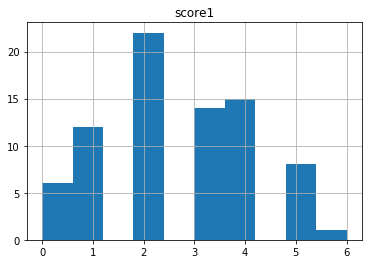

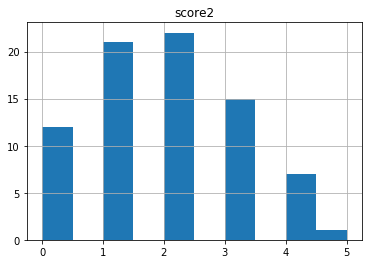

In [215]:
df_liverpool_home.hist('score1')
df_liverpool_away.hist('score2')
print('\n', '-'*25, 'Goal Scored', '-'*25, '\n')

- There were few instance in home, when they did not score and the most frequent score is 1.
- Most frequently scored goal in away is 1 or 2.
- Both the plot suggest, kloop has done well offensively.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125a61650>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125a731d0>]],
      dtype=object)


 ------------------------- Goal Conceded ------------------------- 



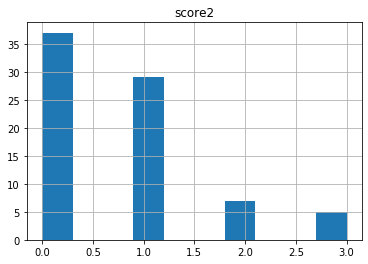

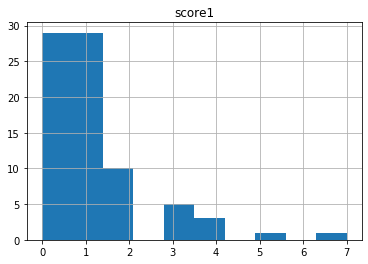

In [216]:
df_liverpool_home.hist('score2')
df_liverpool_away.hist('score1')
print('\n', '-'*25, 'Goal Conceded', '-'*25, '\n')

- Defensive record looks good in home.
- Most frequently, the score was either did not concede a goal or conceded 1 goal for away games.

In [217]:
win_count_h = df_liverpool_home[df_liverpool_home['score1'] > df_liverpool_home['score2']].count().season
draw_count_h = df_liverpool_home[df_liverpool_home['score1'] == df_liverpool_home['score2']].count().season
loss_count_h = df_liverpool_home[df_liverpool_home['score1'] < df_liverpool_home['score2']].count().season
print (f'Home Record \nWon: {win_count_h}, Draw: {draw_count_h}, Loss: {loss_count_h}')

Home Record 
Won: 61, Draw: 15, Loss: 2


In [218]:
win_count_a = df_liverpool_away[df_liverpool_away['score2'] > df_liverpool_away['score1']].count().season
draw_count_a = df_liverpool_away[df_liverpool_away['score1'] == df_liverpool_away['score2']].count().season
loss_count_a = df_liverpool_away[df_liverpool_away['score2'] < df_liverpool_away['score1']].count().season
print (f'Away Record \nWon: {win_count_a}, Draw: {draw_count_a}, Loss: {loss_count_a}')

Away Record 
Won: 47, Draw: 17, Loss: 14


In [219]:
print (f'Overall Record \nWon: {win_count_a + win_count_h}, Draw: {draw_count_a + draw_count_h}, Loss: {loss_count_a + loss_count_h}')

Overall Record 
Won: 108, Draw: 32, Loss: 16


- **Overall record looks good.**

In [220]:
def plot_heatmap(data):
    rcParams['figure.figsize'] = 16, 16
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()

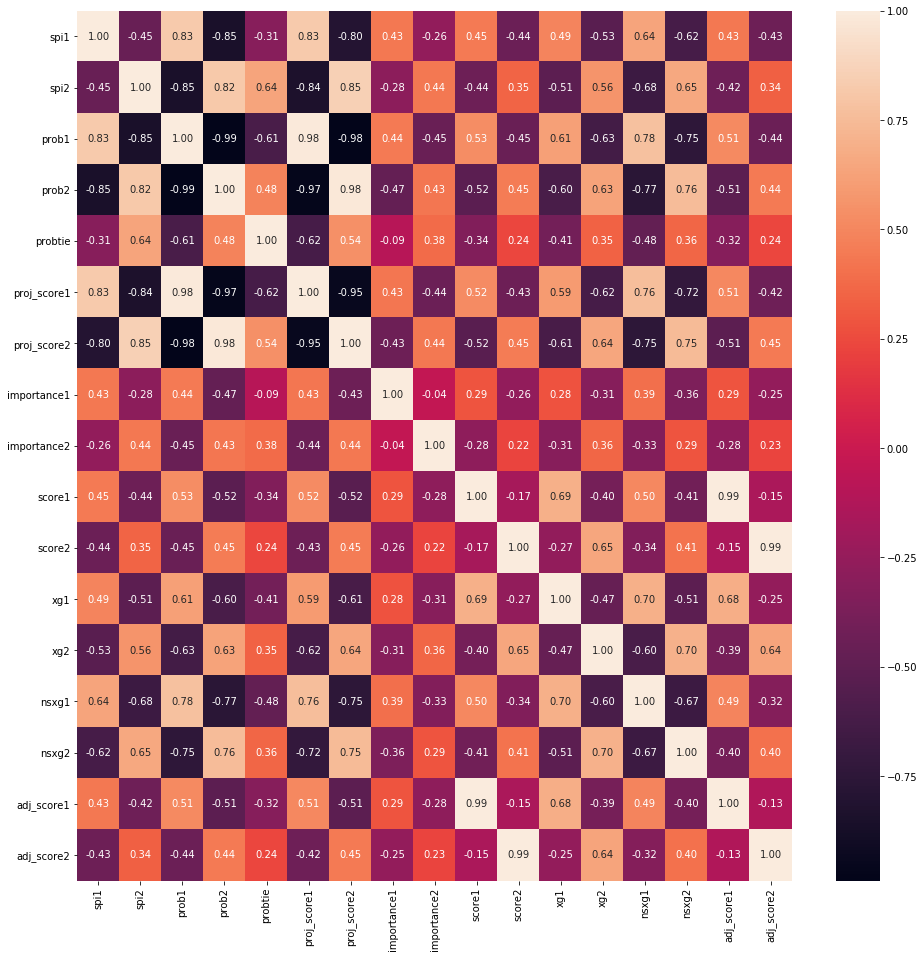

In [221]:
cols = ['spi1',
       'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2',
       'importance1', 'importance2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1',
       'nsxg2', 'adj_score1', 'adj_score2']
plot_heatmap(df_liverpool[cols])

- **We can see that the features with same suffix (either 1 or 2) have high correlation. There is basically a differenciation, when feature with one suffix is positive another is negative and vice versa.**

# Feature Selection
We will remove the row having any null values. All of them are in 2020 season. And select features column as well as label. From the heatmap, we can see that prob1, prob2 and proj_score1, proj_score2 and adj_score1, adj_score2 and score1 and score2 have corelation of almost equal to 1. So, will drop the feature prob1, prob2, adj_score1 and adj_score2. We will use score1 as target and spi1, spi2, pred_score1, pred_score2, importance1, importance2, one hot encoded home and away team as features and later use score2. I will also drop xg1, xg2, nsxg1, nsxg2 first as I have no understanding of what these feature means. I will be limiting our dataset with liverpool as either home or away team.   

The overall data will be split into 75% train and 25% test.

In [222]:
df_liverpool = df_liverpool.dropna()
df_liverpool = pd.concat([df_liverpool, pd.get_dummies(df_liverpool['team1'], prefix='home', )], axis = 1)
df_liverpool = pd.concat([df_liverpool, pd.get_dummies(df_liverpool['team2'], prefix='away')], axis = 1)
df_liverpool.drop(['team1'],axis=1, inplace=True)
df_liverpool.drop(['team2'],axis=1, inplace=True)
df_liverpool.head()

,season,date,league_id,league,spi1,spi2,prob1,prob2,probtie,proj_score1,...,away_Sheffield United,away_Southampton,away_Stoke City,away_Sunderland,away_Swansea City,away_Tottenham Hotspur,away_Watford,away_West Bromwich Albion,away_West Ham United,away_Wolverhampton
26,2016,2016-08-14,2411,Barclays Premier League,82.55,77.44,0.5551,0.2115,0.2334,1.91,...,0,0,0,0,0,0,0,0,0,0
39,2016,2016-08-20,2411,Barclays Premier League,57.85,78.87,0.2079,0.5520,0.2402,1.12,...,0,0,0,0,0,0,0,0,0,0
74,2016,2016-08-27,2411,Barclays Premier League,73.71,78.14,0.3967,0.3444,0.2589,1.58,...,0,0,0,0,0,0,0,0,0,0
145,2016,2016-09-10,2411,Barclays Premier League,78.41,67.06,0.6145,0.1637,0.2218,1.97,...,0,0,0,0,0,0,0,0,0,0
194,2016,2016-09-16,2411,Barclays Premier League,81.72,79.28,0.5080,0.2532,0.2388,1.88,...,0,0,0,0,0,0,0,0,0,0


# USING RANDOM FOREST REGRESSOR
I will use two models with same parameters to predict goal scored and goal conceded respectively.

In [255]:
features_score = df_liverpool.drop(['season', 'date', 'league_id', 'league', 'prob1', 'prob2', 'probtie', 'score1', 'adj_score1', 'adj_score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2'], axis =1)
label_score = df_liverpool['score1']

In [256]:
train_features_s, test_features_s, train_labels_s, test_labels_s = train_test_split(features_score, label_score, test_size = 0.25, random_state = 42)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features_s, train_labels_s);
predictions_s = rf.predict(test_features_s)
errors_s = abs(predictions_s - test_labels_s)
print('Mean Absolute Error:', round(np.mean(errors_s), 2), 'degrees.')


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Mean Absolute Error: 1.06 degrees.


- **The error is slightly greater than one which is good, but now let us add the features with xg and nsxg and check the error.**

In [257]:
features_score1 = df_liverpool.drop(['season', 'date', 'league_id', 'league', 'prob1', 'prob2', 'probtie', 'score1', 'adj_score1', 'adj_score2'], axis =1)
label_score1 = df_liverpool['score1']

In [258]:
train_features_1, test_features_1, train_labels_1, test_labels_1 = train_test_split(features_score1, label_score1, test_size = 0.25, random_state = 42)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features_1, train_labels_1);
predictions_1 = rf.predict(test_features_1)
errors_1 = abs(predictions_1 - test_labels_1)
print('Mean Absolute Error:', round(np.mean(errors_1), 2), 'degrees.')

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Mean Absolute Error: 0.99 degrees.


- **The error decreases below 1% when these features are used.**
- **Let us repeat the model with same parameters changing score2 as the label to predict the goal conceded.**

In [262]:
features_score_c = df_liverpool.drop(['season', 'date', 'league_id', 'league', 'prob1', 'prob2', 'probtie', 'score2', 'adj_score1', 'adj_score2'], axis =1)
label_score_c = df_liverpool['score2']

In [263]:
train_features_c, test_features_c, train_labels_c, test_labels_c = train_test_split(features_score_c, label_score_c, test_size = 0.25, random_state = 42)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features_c, train_labels_c);
predictions_c = rf.predict(test_features_c)
errors_c = abs(predictions_c - test_labels_c)
print('Mean Absolute Error:', round(np.mean(errors_c), 2), 'degrees.')

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Mean Absolute Error: 0.76 degrees.


- **The model for predicting conceding goal looks better.**

# Linear Regression
I will use the same training split generated above with lasso regularization.

In [293]:
reg_s = Lasso(alpha = 0.01)
reg_s.fit(train_features_1, train_labels_1)
pred_s = reg_s.predict(test_features_1)
print("train score: ",reg_s.score(train_features_1,train_labels_1))
print("test score: ", reg_s.score(test_features_1,test_labels_1))

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

train score:  0.6992065501555573
test score:  0.09137534362909894


- **Looking at the test result, I can see that the train data is highly overfitted. This result might be because of dependent features as linear regression assumes features to be independent. Tried changing the value of alpha, both decreasing and increasing it which did not yield satisfactory score.**